In [1]:
# buffer_path = '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_485_20250106-004015/final_buffer.pkl'
# args_path = '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_501_20250105-191146/args.pkl'
# params_path = '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_501_20250105-191146/final.pkl'

In [2]:
#IMPORT STUFF, LOAD PKL, COPY DEFINITIONS (Must be interleaved)
import pickle
import os
import jax
import flax
import tyro
import time
import optax
import wandb
import pickle
import random
import wandb_osh
import numpy as np
import flax.linen as nn
import jax.numpy as jnp

from brax import envs
from etils import epath
from dataclasses import dataclass
from collections import namedtuple
from typing import NamedTuple, Any
from wandb_osh.hooks import TriggerWandbSyncHook
from flax.training.train_state import TrainState
from flax.linen.initializers import variance_scaling
from brax.io import html
from brax.io import model

from evaluator import CrlEvaluator
from buffer import TrajectoryUniformSamplingQueue
from memory_bank import MemoryBank, MemoryBankState

In [3]:
#COPY OVER DEFINITIONS
@dataclass
class Args:
    exp_name: str = "train" # os.path.basename(__file__)[: -len(".py")]
    seed: int = random.randint(1, 1000) # 16
    torch_deterministic: bool = True
    cuda: bool = True
    track: bool = True
    wandb_project_name: str = "clean_JaxGCRL_test"
    wandb_entity: str = 'wang-kevin3290-princeton-university'
    wandb_mode: str = 'offline'
    wandb_dir: str = '.'
    wandb_group: str = '.'
    capture_vis: bool = True
    vis_length: int = 1000
    checkpoint: bool = True

    #environment specific arguments
    env_id: str = "humanoid" # "ant_push" "ant_hardest_maze" "ant_big_maze" "humanoid" "ant"
    episode_length: int = 1000
    # to be filled in runtime
    obs_dim: int = 0
    goal_start_idx: int = 0
    goal_end_idx: int = 0

    # Algorithm specific arguments
    total_env_steps: int = 100000000 # 50000000
    num_epochs: int = 100 # 50
    num_envs: int = 512
    eval_env_id: str = ""
    num_eval_envs: int = 128
    actor_lr: float = 3e-4
    critic_lr: float = 3e-4
    alpha_lr: float = 3e-4
    batch_size: int = 256
    gamma: float = 0.99
    logsumexp_penalty_coeff: float = 0.1
    
    #adding in a batch_size_multiplier argument for critic vs. actor batch size
    critic_batch_size_multiplier: float = 1.0 #this has to be less than or equal to 1
    actor_batch_size_multiplier: float = 1.0 #this has to be less than 1

    max_replay_size: int = 10000
    min_replay_size: int = 1000
    
    unroll_length: int  = 62
    
    # ADDING IN A NETWORK WIDTH ARGUMENT
    same_network_width: int = 0
    network_width: int = 256
    critic_network_width: int = 256
    actor_network_width: int = 256
    actor_depth: int = 4
    critic_depth: int = 4
    actor_skip_connections: int = 0 # 0 for no skip connections, >= 0 means the frequency of skip connections (every X layers)
    critic_skip_connections: int = 0 # 0 for no skip connections, >= 0 means the frequency of skip connections (every X layers)
    
    num_episodes_per_env: int = 1 #the number of episodes to sample from each env when sampling data 
    #(to ensure number of batches is consistent as increase batch_size; for now, just a bandaid fix)
    # should be something like batch_size / 256
    training_steps_multiplier: int = 1 #should have the same effect as num_episodes_per_env, hmmm
    use_all_batches: int = 0 # if 1, use all batches; if 0, use a random subset of batches
    num_sgd_batches_per_training_step: int = 800 # this parameter so as to hold the number of batches constant (no matter batch_size, etc)
    
    mrn: int = 0
    memory_bank: int = 0
    memory_bank_size: int = batch_size # this can be modified too
    
    batchdiv2: int = 0 
    # if 1, freeze gradients for second half of batch
    # if 2, split in half along sa and freeze second half of g (Eysenbach ablation, remember it's forward loss)
    #
    # use batch_size * 2 and split in half and freeze gradients and all that (Eysenbach ablation), does not 
    # TODO: if 2, modifies actor such that it uses the half batch size (isolate for critic ablation)
    # can add 3, 4, etc (if diff between 1 and 2, maybe for batch_size ablation we need to have separate for actor and critic)
    # add more for instead of discarding second half, just freeze gradients for second half so symmetric with first
    
    eval_actor: int = 0
    # if 0, use deterministic actor for evaluation
    # if 1, use stochastic actor for evaluation
    # if 2, sample two actions and take the one with the higher Q value
    # if K >= 2, sample K actions and take the one with the highest Q value
    expl_actor: int = 1
    # if 0, use deterministic actor for exploration/collecting data
    # if 1, use stochastic actor for exploration/collecting data
    # if 2, sample two actions and take the one with the higher Q value
    # if K >= 2, sample K actions and take the one with the highest Q value
    
    entropy_param: float = 0.5
    disable_entropy: int = 0
    
    use_relu: int = 0
    
    resnet: str = "noishmistake4_nodense"
    
    num_render: int = 10
    
    
    
    # to be filled in runtime
    env_steps_per_actor_step : int = 0
    """number of env steps per actor step (computed in runtime)"""
    num_prefill_env_steps : int = 0
    """number of env steps to fill the buffer before starting training (computed in runtime)"""
    num_prefill_actor_steps : int = 0
    """number of actor steps to fill the buffer before starting training (computed in runtime)"""
    num_training_steps_per_epoch : int = 0
    """the number of training steps per epoch(computed in runtime)"""

In [4]:
def make_env(env_id, args):
    print(f"making env with env_id: {env_id}", flush=True)
    if env_id == "reacher":
        from envs.reacher import Reacher
        env = Reacher(
            backend="spring",
        )
        args.obs_dim = 10
        args.goal_start_idx = 4
        args.goal_end_idx = 7
    elif env_id == "pusher":
        from envs.pusher import Pusher
        env = Pusher(
            backend="spring",
        )
        args.obs_dim = 20
        args.goal_start_idx = 10
        args.goal_end_idx = 13
    elif env_id == "ant":
        from envs.ant import Ant
        env = Ant(
            backend="spring",
            exclude_current_positions_from_observation=False,
            terminate_when_unhealthy=True,
        )

        args.obs_dim = 29
        args.goal_start_idx = 0
        args.goal_end_idx = 2

    elif "ant" in env_id and "maze" in env_id: #needed the add the ant check to differentiate with humanoid maze
        if "gen" not in env_id:
            from envs.ant_maze import AntMaze
            env = AntMaze(
                backend="spring",
                exclude_current_positions_from_observation=False,
                terminate_when_unhealthy=True,
                maze_layout_name=env_id[4:]
            )

            args.obs_dim = 29
            args.goal_start_idx = 0
            args.goal_end_idx = 2
        else:
            from envs.ant_maze_generalization import AntMazeGeneralization
            gen_idx = env_id.find("gen")
            maze_layout_name = env_id[4:gen_idx-1]
            generalization_config = env_id[gen_idx+4:]
            print(f"maze_layout_name: {maze_layout_name}, generalization_config: {generalization_config}", flush=True)
            env = AntMazeGeneralization(
                backend="spring",
                exclude_current_positions_from_observation=False,
                terminate_when_unhealthy=True,
                maze_layout_name=maze_layout_name,
                generalization_config=generalization_config
            )

            args.obs_dim = 29
            args.goal_start_idx = 0
            args.goal_end_idx = 2
    
    elif env_id == "ant_ball":
        from envs.ant_ball import AntBall
        env = AntBall(
            backend="spring",
            exclude_current_positions_from_observation=False,
            terminate_when_unhealthy=True,
        )

        args.obs_dim = 31
        args.goal_start_idx = 28
        args.goal_end_idx = 30

    elif env_id == "ant_push":
        from envs.ant_push import AntPush
        env = AntPush(
            backend="mjx",
        )

        args.obs_dim = 31
        args.goal_start_idx = 0
        args.goal_end_idx = 2
        
    elif env_id == "humanoid":
        from envs.humanoid import Humanoid
        env = Humanoid(
            backend="spring",
            exclude_current_positions_from_observation=False,
            terminate_when_unhealthy=True,
        )

        args.obs_dim = 268
        args.goal_start_idx = 0
        args.goal_end_idx = 3
        
    elif "humanoid" in env_id and "maze" in env_id:
        from envs.humanoid_maze import HumanoidMaze
        env = HumanoidMaze(
            backend="spring",
            maze_layout_name=env_id[9:]
        )

        args.obs_dim = 268
        args.goal_start_idx = 0
        args.goal_end_idx = 3

        
    elif env_id == "arm_reach":
        from envs.manipulation.arm_reach import ArmReach
        env = ArmReach(
            backend="mjx",
        )

        args.obs_dim = 13
        args.goal_start_idx = 7
        args.goal_end_idx = 10
        
    elif env_id == "arm_binpick_easy":
        from envs.manipulation.arm_binpick_easy import ArmBinpickEasy
        env = ArmBinpickEasy(
            backend="mjx",
        )

        args.obs_dim = 17
        args.goal_start_idx = 0
        args.goal_end_idx = 3
        
    elif env_id == "arm_binpick_hard":
        from envs.manipulation.arm_binpick_hard import ArmBinpickHard
        env = ArmBinpickHard(
            backend="mjx",
        )

        args.obs_dim = 17
        args.goal_start_idx = 0
        args.goal_end_idx = 3
        
    elif env_id == "arm_binpick_easy_EEF":
        from envs.manipulation.arm_binpick_easy_EEF import ArmBinpickEasyEEF
        env = ArmBinpickEasyEEF(
            backend="mjx",
        )

        args.obs_dim = 11
        args.goal_start_idx = 0
        args.goal_end_idx = 3
    
    elif "arm_grasp" in env_id: # either arm_grasp or arm_grasp_0.5, etc
        from envs.manipulation.arm_grasp import ArmGrasp
        cube_noise_scale = float(env_id[10:]) if len(env_id) > 9 else 0.3
        env = ArmGrasp(
            cube_noise_scale=cube_noise_scale,
            backend="mjx",
        )

        args.obs_dim = 23
        args.goal_start_idx = 16
        args.goal_end_idx = 23
    
    elif env_id == "arm_push_easy":
        from envs.manipulation.arm_push_easy import ArmPushEasy
        env = ArmPushEasy(
            backend="mjx",
        )

        args.obs_dim = 17
        args.goal_start_idx = 0
        args.goal_end_idx = 3
    
    elif env_id == "arm_push_hard":
        from envs.manipulation.arm_push_hard import ArmPushHard
        env = ArmPushHard(
            backend="mjx",
        )

        args.obs_dim = 17
        args.goal_start_idx = 0
        args.goal_end_idx = 3

    else:
        raise NotImplementedError
    
    return env

In [5]:
lecun_unfirom = variance_scaling(1/3, "fan_in", "uniform")
bias_init = nn.initializers.zeros
def residual_block(x, width, normalize, activation):
    identity = x
    x = nn.Dense(width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
    x = normalize(x)
    x = activation(x)
    x = nn.Dense(width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
    x = normalize(x)
    x = activation(x)
    x = nn.Dense(width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
    x = normalize(x)
    x = activation(x)
    x = nn.Dense(width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
    x = normalize(x)
    x = activation(x)
    x = x + identity
    return x

class SA_encoder(nn.Module):
    norm_type = "layer_norm"
    network_width: int = 1024
    network_depth: int = 4
    skip_connections: int = 0
    use_relu: int = 0
    @nn.compact
    def __call__(self, s: jnp.ndarray, a: jnp.ndarray):

        lecun_unfirom = variance_scaling(1/3, "fan_in", "uniform")
        bias_init = nn.initializers.zeros
        
        if self.norm_type == "layer_norm":
            normalize = lambda x: nn.LayerNorm()(x)
        else:
            normalize = lambda x: x
        
        if self.use_relu:
            activation = nn.relu
        else:
            activation = nn.swish
            
        x = jnp.concatenate([s, a], axis=-1)
        #Initial layer
        x = nn.Dense(self.network_width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        x = normalize(x)
        x = activation(x)
        #Residual blocks
        for i in range(self.network_depth // 4):
            x = residual_block(x, self.network_width, normalize, activation)
        #Final layer
        x = nn.Dense(64, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        return x
    
class G_encoder(nn.Module):
    norm_type = "layer_norm"
    network_width: int = 1024
    network_depth: int = 4
    skip_connections: int = 0
    use_relu: int = 0
    @nn.compact
    def __call__(self, g: jnp.ndarray):

        lecun_unfirom = variance_scaling(1/3, "fan_in", "uniform")
        bias_init = nn.initializers.zeros

        if self.norm_type == "layer_norm":
            normalize = lambda x: nn.LayerNorm()(x)
        else:
            normalize = lambda x: x
        
        if self.use_relu:
            activation = nn.relu
        else:
            activation = nn.swish
        
        x = g
        #Initial layer
        x = nn.Dense(self.network_width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        x = normalize(x)
        x = activation(x)
        #Residual blocks
        for i in range(self.network_depth // 4):
            x = residual_block(x, self.network_width, normalize, activation)
        #Final layer
        x = nn.Dense(64, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        return x

class Actor(nn.Module):
    action_size: int
    norm_type = "layer_norm"
    network_width: int = 1024
    network_depth: int = 4
    skip_connections: int = 0 # 0 for no skip connections, >= 0 means the frequency of skip connections (every X layers)
    use_relu: int = 0
    LOG_STD_MAX = 2
    LOG_STD_MIN = -5

    @nn.compact
    def __call__(self, x):
        if self.norm_type == "layer_norm":
            normalize = lambda x: nn.LayerNorm()(x)
        else:
            normalize = lambda x: x
            
        if self.use_relu:
            activation = nn.relu
        else:
            activation = nn.swish

        lecun_unfirom = variance_scaling(1/3, "fan_in", "uniform")
        bias_init = nn.initializers.zeros
        
        #Initial layer
        x = nn.Dense(self.network_width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        x = normalize(x)
        x = activation(x)
        #Residual blocks
        for i in range(self.network_depth // 4):
            x = residual_block(x, self.network_width, normalize, activation)
        #Final layer
        # x = nn.Dense(64, kernel_init=lecun_unfirom, bias_init=bias_init)(x)

        mean = nn.Dense(self.action_size, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        log_std = nn.Dense(self.action_size, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        
        log_std = nn.tanh(log_std)
        log_std = self.LOG_STD_MIN + 0.5 * (self.LOG_STD_MAX - self.LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

In [8]:
with open(buffer_path, 'rb') as f:
    buffer_data = pickle.load(f)
with open(args_path, 'rb') as f:
    args = pickle.load(f)

In [9]:
#Recreate replay buffer
env = make_env(args.env_id)
env = envs.training.wrap(
    env,
    episode_length=args.episode_length,
)

obs_size = env.observation_size
action_size = env.action_size

class Transition(NamedTuple):
    """Container for a transition"""
    observation: jnp.ndarray
    action: jnp.ndarray
    reward: jnp.ndarray
    discount: jnp.ndarray
    extras: jnp.ndarray = ()

# Recreate the buffer object
dummy_obs = jnp.zeros((obs_size,))
dummy_action = jnp.zeros((action_size,))

dummy_transition = Transition(
    observation=dummy_obs,
    action=dummy_action,
    reward=0.0,
    discount=0.0,
    extras={
        "state_extras": {
            "truncation": 0.0,
            "seed": 0.0,
        }
    },
)
replay_buffer = TrajectoryUniformSamplingQueue(
    max_replay_size=buffer_data['max_replay_size'],
    dummy_data_sample=dummy_transition,  # You'll need to recreate this
    sample_batch_size=buffer_data['batch_size'],
    num_envs=buffer_data['num_envs'],
    episode_length=buffer_data['episode_length'],
)

buffer_state = buffer_data['buffer_state']

making env with env_id: humanoid
data_size: 292


In [10]:
#load models

In [11]:
params = model.load_params(params_path)
alpha_params, actor_params, critic_params = params
sa_encoder_params, g_encoder_params = critic_params['sa_encoder'], critic_params['g_encoder']


actor = Actor(action_size=action_size, network_width=args.actor_network_width, network_depth=args.actor_depth, skip_connections=args.actor_skip_connections, use_relu=args.use_relu)
sa_encoder = SA_encoder(network_width=args.critic_network_width, network_depth=args.critic_depth, skip_connections=args.critic_skip_connections, use_relu=args.use_relu)
g_encoder = G_encoder(network_width=args.critic_network_width, network_depth=args.critic_depth, skip_connections=args.critic_skip_connections, use_relu=args.use_relu)

In [12]:
#extract all transitions from replay buffer
# After loading buffer_state from pickle file
def extract_all_transitions(buffer_state, replay_buffer, args):
    """Extract all transitions from the buffer."""
    print("Extracting transitions from buffer...", flush=True)
    
    # Sample transitions from buffer (similar to training code)
    transitions_list = []
    temp_buffer_state = buffer_state  # Create temporary copy to not modify original
    
    for i in range(args.num_episodes_per_env):
        print(f"{i} out of {args.num_episodes_per_env}")
        temp_buffer_state, new_transitions = replay_buffer.sample(temp_buffer_state)
        transitions_list.append(new_transitions)

    # Concatenate all sampled transitions
    transitions = jax.tree_util.tree_map(
        lambda *arrays: jnp.concatenate(arrays, axis=0),
        *transitions_list
    )

    # Process transitions (same as in training)
    key = jax.random.PRNGKey(0)  # or any seed
    batch_keys = jax.random.split(key, transitions.observation.shape[0])
    transitions = jax.vmap(TrajectoryUniformSamplingQueue.flatten_crl_fn, in_axes=(None, 0, 0))(
        (args.gamma, args.obs_dim, args.goal_start_idx, args.goal_end_idx), 
        transitions, 
        batch_keys
    )
    
    transitions = jax.tree_util.tree_map(
        lambda x: jnp.reshape(x, (-1,) + x.shape[2:], order="F"),
        transitions,
    )
    
    return transitions

# Usage:
transitions = extract_all_transitions(buffer_state, replay_buffer, args)
print(f"Extracted transitions shape: {transitions.observation.shape}")

Extracting transitions from buffer...
0 out of 1
buffer_state.data[:, envs_idxs, :].shape: (10000, 512, 292)
Extracted transitions shape: (511488, 271)


In [13]:
# Split transitions into batches
num_transitions = len(transitions.observation)
num_batches = num_transitions // args.batch_size

print(f"Total transitions: {num_transitions}")
print(f"Number of batches: {num_batches}")

# Reshape transitions into batches
batched_transitions = jax.tree_util.tree_map(
    lambda x: x[:num_batches * args.batch_size].reshape(num_batches, args.batch_size, *x.shape[1:]),
    transitions
)

Total transitions: 511488
Number of batches: 999


In [14]:
# Compute losses
def compute_critic_loss(transitions, critic_params):
    sa_encoder_params, g_encoder_params = critic_params["sa_encoder"], critic_params["g_encoder"]
    
    obs = transitions.observation[:, :args.obs_dim]
    action = transitions.action
    
    sa_repr = sa_encoder.apply(sa_encoder_params, obs, action)
    g_repr = g_encoder.apply(g_encoder_params, transitions.observation[:, args.obs_dim:])
    
    logits = -jnp.sqrt(jnp.sum((sa_repr[:, None, :] - g_repr[None, :, :]) ** 2, axis=-1))
    critic_loss = -jnp.mean(jnp.diag(logits) - jax.nn.logsumexp(logits, axis=1))
    
    return critic_loss

def compute_actor_loss(transitions, actor_params, critic_params, alpha):
    obs = transitions.observation
    state = obs[:, :args.obs_dim]
    future_state = transitions.extras["future_state"]
    goal = future_state[:, args.goal_start_idx : args.goal_end_idx]
    observation = jnp.concatenate([state, goal], axis=1)

    means, log_stds = actor.apply(actor_params, observation)
    stds = jnp.exp(log_stds)
    key = jax.random.PRNGKey(0)
    x_ts = means + stds * jax.random.normal(key, shape=means.shape)
    action = nn.tanh(x_ts)
    log_prob = jax.scipy.stats.norm.logpdf(x_ts, loc=means, scale=stds)
    log_prob -= jnp.log((1 - jnp.square(action)) + 1e-6)
    log_prob = log_prob.sum(-1)

    sa_encoder_params, g_encoder_params = critic_params["sa_encoder"], critic_params["g_encoder"]
    sa_repr = sa_encoder.apply(sa_encoder_params, state, action)
    g_repr = g_encoder.apply(g_encoder_params, goal)

    qf_pi = -jnp.sqrt(jnp.sum((sa_repr - g_repr) ** 2, axis=-1))

    if args.disable_entropy:
        actor_loss = -jnp.mean(qf_pi)
    else:
        actor_loss = jnp.mean(jnp.exp(alpha) * log_prob - qf_pi)
    
    return actor_loss

In [ ]:
# Compute losses for each batch
critic_losses = []
actor_losses = []

for batch_idx in range(num_batches):
    batch_transitions = jax.tree_util.tree_map(
        lambda x: x[batch_idx],
        batched_transitions
    )
    
    critic_loss = compute_critic_loss(batch_transitions, critic_params)
    actor_loss = compute_actor_loss(
        batch_transitions, 
        actor_params, 
        critic_params, 
        alpha_params['log_alpha']
    )
    
    critic_losses.append(critic_loss)
    actor_losses.append(actor_loss)
    
    if batch_idx % 100 == 0:
        print(f"Batch {batch_idx}/{num_batches}:")
        print(f"  Critic loss: {critic_loss}")
        print(f"  Actor loss: {actor_loss}")

# Compute statistics
critic_losses = jnp.array(critic_losses)
actor_losses = jnp.array(actor_losses)

results = {
    'critic_loss_mean': jnp.mean(critic_losses),
    'critic_loss_std': jnp.std(critic_losses),
    'critic_loss_min': jnp.min(critic_losses),
    'critic_loss_max': jnp.max(critic_losses),
    'actor_loss_mean': jnp.mean(actor_losses),
    'actor_loss_std': jnp.std(actor_losses),
    'actor_loss_min': jnp.min(actor_losses),
    'actor_loss_max': jnp.max(actor_losses),
}

print("\nFinal Statistics:")
for key, value in results.items():
    print(f"{key}: {value}")

Batch 0/999:
  Critic loss: 2.7609364986419678
  Actor loss: 3.4282493591308594
Batch 100/999:
  Critic loss: 2.841352939605713
  Actor loss: 3.4898836612701416
Batch 200/999:
  Critic loss: 2.6949715614318848
  Actor loss: 3.38303804397583
Batch 300/999:
  Critic loss: 2.522019386291504
  Actor loss: 3.2226319313049316
Batch 400/999:
  Critic loss: 2.7264249324798584
  Actor loss: 3.4261765480041504
Batch 500/999:
  Critic loss: 2.6922414302825928
  Actor loss: 3.388977527618408
Batch 600/999:
  Critic loss: 2.6108431816101074
  Actor loss: 3.261474609375
Batch 700/999:
  Critic loss: 2.8305130004882812
  Actor loss: 3.533977508544922
Batch 800/999:
  Critic loss: 2.6680679321289062
  Actor loss: 3.276273488998413


In [6]:
def compute_loss(buffer_path, args_path, params_path, max_batches=None):
    with open(buffer_path, 'rb') as f:
        buffer_data = pickle.load(f)
    with open(args_path, 'rb') as f:
        args = pickle.load(f)

    
    #Recreate replay buffer
    env = make_env(args.env_id, args)
    env = envs.training.wrap(
        env,
        episode_length=args.episode_length,
    )
    
    obs_size = env.observation_size
    action_size = env.action_size
    
    class Transition(NamedTuple):
        """Container for a transition"""
        observation: jnp.ndarray
        action: jnp.ndarray
        reward: jnp.ndarray
        discount: jnp.ndarray
        extras: jnp.ndarray = ()
    
    # Recreate the buffer object
    dummy_obs = jnp.zeros((obs_size,))
    dummy_action = jnp.zeros((action_size,))
    
    dummy_transition = Transition(
        observation=dummy_obs,
        action=dummy_action,
        reward=0.0,
        discount=0.0,
        extras={
            "state_extras": {
                "truncation": 0.0,
                "seed": 0.0,
            }
        },
    )
    replay_buffer = TrajectoryUniformSamplingQueue(
        max_replay_size=buffer_data['max_replay_size'],
        dummy_data_sample=dummy_transition,  # You'll need to recreate this
        sample_batch_size=buffer_data['batch_size'],
        num_envs=buffer_data['num_envs'],
        episode_length=buffer_data['episode_length'],
    )
    
    buffer_state = buffer_data['buffer_state']





    params = model.load_params(params_path)
    alpha_params, actor_params, critic_params = params
    sa_encoder_params, g_encoder_params = critic_params['sa_encoder'], critic_params['g_encoder']
    
    
    actor = Actor(action_size=action_size, network_width=args.actor_network_width, network_depth=args.actor_depth, skip_connections=args.actor_skip_connections, use_relu=args.use_relu)
    sa_encoder = SA_encoder(network_width=args.critic_network_width, network_depth=args.critic_depth, skip_connections=args.critic_skip_connections, use_relu=args.use_relu)
    g_encoder = G_encoder(network_width=args.critic_network_width, network_depth=args.critic_depth, skip_connections=args.critic_skip_connections, use_relu=args.use_relu)


    #extract all transitions from replay buffer
    # After loading buffer_state from pickle file
    def extract_all_transitions(buffer_state, replay_buffer, args):
        """Extract all transitions from the buffer."""
        print("Extracting transitions from buffer...", flush=True)
        
        # Sample transitions from buffer (similar to training code)
        transitions_list = []
        temp_buffer_state = buffer_state  # Create temporary copy to not modify original
        
        for i in range(args.num_episodes_per_env):
            print(f"{i} out of {args.num_episodes_per_env}")
            temp_buffer_state, new_transitions = replay_buffer.sample(temp_buffer_state)
            transitions_list.append(new_transitions)
    
        # Concatenate all sampled transitions
        transitions = jax.tree_util.tree_map(
            lambda *arrays: jnp.concatenate(arrays, axis=0),
            *transitions_list
        )
    
        # Process transitions (same as in training)
        key = jax.random.PRNGKey(0)  # or any seed
        batch_keys = jax.random.split(key, transitions.observation.shape[0])
        transitions = jax.vmap(TrajectoryUniformSamplingQueue.flatten_crl_fn, in_axes=(None, 0, 0))(
            (args.gamma, args.obs_dim, args.goal_start_idx, args.goal_end_idx), 
            transitions, 
            batch_keys
        )
        
        transitions = jax.tree_util.tree_map(
            lambda x: jnp.reshape(x, (-1,) + x.shape[2:], order="F"),
            transitions,
        )
        
        return transitions
    
    # Usage:
    transitions = extract_all_transitions(buffer_state, replay_buffer, args)
    print(f"Extracted transitions shape: {transitions.observation.shape}")


    # Split transitions into batches
    num_transitions = len(transitions.observation)
    num_batches = num_transitions // args.batch_size
    
    print(f"Total transitions: {num_transitions}")
    print(f"Number of batches: {num_batches}")
    
    # Reshape transitions into batches
    batched_transitions = jax.tree_util.tree_map(
        lambda x: x[:num_batches * args.batch_size].reshape(num_batches, args.batch_size, *x.shape[1:]),
        transitions
    )


    # Compute losses
    def compute_critic_loss(transitions, critic_params):
        sa_encoder_params, g_encoder_params = critic_params["sa_encoder"], critic_params["g_encoder"]
        
        obs = transitions.observation[:, :args.obs_dim]
        action = transitions.action
        
        sa_repr = sa_encoder.apply(sa_encoder_params, obs, action)
        g_repr = g_encoder.apply(g_encoder_params, transitions.observation[:, args.obs_dim:])
        
        logits = -jnp.sqrt(jnp.sum((sa_repr[:, None, :] - g_repr[None, :, :]) ** 2, axis=-1))
        critic_loss = -jnp.mean(jnp.diag(logits) - jax.nn.logsumexp(logits, axis=1))
        
        return critic_loss
    
    def compute_actor_loss(transitions, actor_params, critic_params, alpha):
        obs = transitions.observation
        state = obs[:, :args.obs_dim]
        future_state = transitions.extras["future_state"]
        goal = future_state[:, args.goal_start_idx : args.goal_end_idx]
        observation = jnp.concatenate([state, goal], axis=1)
    
        means, log_stds = actor.apply(actor_params, observation)
        stds = jnp.exp(log_stds)
        key = jax.random.PRNGKey(0)
        x_ts = means + stds * jax.random.normal(key, shape=means.shape)
        action = nn.tanh(x_ts)
        log_prob = jax.scipy.stats.norm.logpdf(x_ts, loc=means, scale=stds)
        log_prob -= jnp.log((1 - jnp.square(action)) + 1e-6)
        log_prob = log_prob.sum(-1)
    
        sa_encoder_params, g_encoder_params = critic_params["sa_encoder"], critic_params["g_encoder"]
        sa_repr = sa_encoder.apply(sa_encoder_params, state, action)
        g_repr = g_encoder.apply(g_encoder_params, goal)
    
        qf_pi = -jnp.sqrt(jnp.sum((sa_repr - g_repr) ** 2, axis=-1))
    
        if args.disable_entropy:
            actor_loss = -jnp.mean(qf_pi)
        else:
            actor_loss = jnp.mean(jnp.exp(alpha) * log_prob - qf_pi)
        
        return actor_loss


    # Compute losses for each batch
    critic_losses = []
    actor_losses = []

    num_batches = max_batches if max_batches else num_batches
    for batch_idx in range(num_batches):
        batch_transitions = jax.tree_util.tree_map(
            lambda x: x[batch_idx],
            batched_transitions
        )
        
        critic_loss = compute_critic_loss(batch_transitions, critic_params)
        actor_loss = compute_actor_loss(
            batch_transitions, 
            actor_params, 
            critic_params, 
            alpha_params['log_alpha']
        )
        
        critic_losses.append(critic_loss)
        actor_losses.append(actor_loss)
        
        if batch_idx % 20 == 0:
            print(f"Batch {batch_idx}/{num_batches}:")
            print(f"  Critic loss: {critic_loss}")
            print(f"  Actor loss: {actor_loss}")
    
    # Compute statistics
    critic_losses = jnp.array(critic_losses)
    actor_losses = jnp.array(actor_losses)
    
    results = {
        'critic_loss_mean': jnp.mean(critic_losses),
        'critic_loss_std': jnp.std(critic_losses),
        'critic_loss_min': jnp.min(critic_losses),
        'critic_loss_max': jnp.max(critic_losses),
        'actor_loss_mean': jnp.mean(actor_losses),
        'actor_loss_std': jnp.std(actor_losses),
        'actor_loss_min': jnp.min(actor_losses),
        'actor_loss_max': jnp.max(actor_losses),
    }
    
    print("\nFinal Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")

    return results, results['critic_loss_mean'], results['actor_loss_mean']

In [7]:
results, critic_loss, actor_loss = compute_loss(buffer_path, args_path, params_path, max_batches=10)

Args(exp_name='train', seed=501, torch_deterministic=True, cuda=True, track=True, wandb_project_name='clean_JaxGCRL_test', wandb_entity='wang-kevin3290-princeton-university', wandb_mode='offline', wandb_dir='.', wandb_group=None, capture_vis=True, vis_length=1000, checkpoint=True, env_id='humanoid', episode_length=1000, obs_dim=268, goal_start_idx=0, goal_end_idx=3, total_env_steps=100000000, num_epochs=100, num_envs=512, eval_env_id='humanoid', num_eval_envs=128, actor_lr=0.0003, critic_lr=0.0003, alpha_lr=0.0003, batch_size=512, gamma=0.99, logsumexp_penalty_coeff=0.1, critic_batch_size_multiplier=1.0, actor_batch_size_multiplier=1.0, max_replay_size=10000, min_replay_size=1000, unroll_length=62, same_network_width=0, network_width=256, critic_network_width=256, actor_network_width=256, actor_depth=4, critic_depth=4, actor_skip_connections=4, critic_skip_connections=4, num_episodes_per_env=1, training_steps_multiplier=1, use_all_batches=0, num_sgd_batches_per_training_step=800, mrn=0

In [9]:
results, critic_loss, actor_loss = compute_loss(buffer_path, args_path, params_path, max_batches=10)

Args(exp_name='train', seed=501, torch_deterministic=True, cuda=True, track=True, wandb_project_name='clean_JaxGCRL_test', wandb_entity='wang-kevin3290-princeton-university', wandb_mode='offline', wandb_dir='.', wandb_group=None, capture_vis=True, vis_length=1000, checkpoint=True, env_id='humanoid', episode_length=1000, obs_dim=268, goal_start_idx=0, goal_end_idx=3, total_env_steps=100000000, num_epochs=100, num_envs=512, eval_env_id='humanoid', num_eval_envs=128, actor_lr=0.0003, critic_lr=0.0003, alpha_lr=0.0003, batch_size=512, gamma=0.99, logsumexp_penalty_coeff=0.1, critic_batch_size_multiplier=1.0, actor_batch_size_multiplier=1.0, max_replay_size=10000, min_replay_size=1000, unroll_length=62, same_network_width=0, network_width=256, critic_network_width=256, actor_network_width=256, actor_depth=4, critic_depth=4, actor_skip_connections=4, critic_skip_connections=4, num_episodes_per_env=1, training_steps_multiplier=1, use_all_batches=0, num_sgd_batches_per_training_step=800, mrn=0

In [15]:
buffer_path = '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_485_20250106-004015/final_buffer.pkl' #64

In [21]:
buffer_path = '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_946_20250106-005356/final_buffer.pkl' #4

In [16]:
testee_dirs = {
    4: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_501_20250105-191146',
    8: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_889_20250105-190649',
    16: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_715_20250105-190649',
    32: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_456_20250105-190225',
    64: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_758_20250105-190051',
    100: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_909_20250105-190051',
}
depths = [4, 8, 16, 32, 64, 100]

In [22]:
testee_dirs = {
    4: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_671_20250105-181659',
    8: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_519_20250105-181259',
    16: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_856_20250105-180537',
    32: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_186_20250105-180537',
    64: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_550_20250105-180444',
    100: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/humanoid_183_20250105-180346',
}
depths = [4, 8, 16, 32, 64, 100]

In [23]:
from collections import defaultdict
critic_losses = defaultdict(float)
actor_losses = defaultdict(float)
for depth in depths:
    print(f"\n\nCOMPUTING LOSS FOR DEPTH {depth}\n")
    args_path = f'{testee_dirs[depth]}/args.pkl'
    params_path = f'{testee_dirs[depth]}/final.pkl'
    results, critic_loss, actor_loss = compute_loss(buffer_path, args_path, params_path, max_batches=100)
    critic_losses[depth] = critic_loss
    actor_losses[depth] = actor_loss
    print(f"depth {depth} has critic_loss {critic_loss} and actor_loss {actor_loss}")



COMPUTING LOSS FOR DEPTH 4

Args(exp_name='train', seed=671, torch_deterministic=True, cuda=True, track=True, wandb_project_name='clean_JaxGCRL_test', wandb_entity='wang-kevin3290-princeton-university', wandb_mode='offline', wandb_dir='.', wandb_group=None, capture_vis=True, vis_length=1000, checkpoint=True, env_id='humanoid', episode_length=1000, obs_dim=268, goal_start_idx=0, goal_end_idx=3, total_env_steps=100000000, num_epochs=100, num_envs=512, eval_env_id='humanoid', num_eval_envs=128, actor_lr=0.0003, critic_lr=0.0003, alpha_lr=0.0003, batch_size=512, gamma=0.99, logsumexp_penalty_coeff=0.1, critic_batch_size_multiplier=1.0, actor_batch_size_multiplier=1.0, max_replay_size=10000, min_replay_size=1000, unroll_length=62, same_network_width=0, network_width=256, critic_network_width=256, actor_network_width=256, actor_depth=4, critic_depth=4, actor_skip_connections=4, critic_skip_connections=4, num_episodes_per_env=1, training_steps_multiplier=1, use_all_batches=0, num_sgd_batche

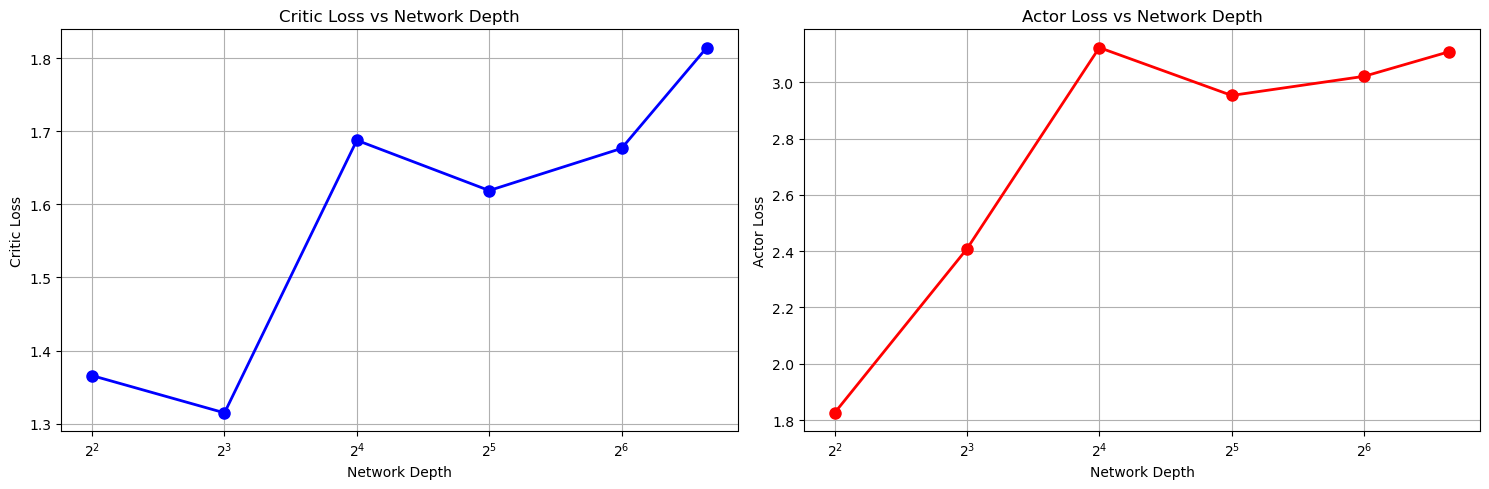


Numerical Values:
Depth | Critic Loss | Actor Loss
-----------------------------------
    4 |     1.3658 |     1.8256
    8 |     1.3148 |     2.4084
   16 |     1.6876 |     3.1231
   32 |     1.6188 |     2.9531
   64 |     1.6765 |     3.0210
  100 |     1.8143 |     3.1086


In [10]:
#BUFFER: 64, testees: set 1

import matplotlib.pyplot as plt
import numpy as np

# Convert defaultdict to regular dictionaries for easier plotting
depths = list(critic_losses.keys())
critic_values = [critic_losses[d] for d in depths]
actor_values = [actor_losses[d] for d in depths]

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Critic Losses
ax1.plot(depths, critic_values, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Network Depth')
ax1.set_ylabel('Critic Loss')
ax1.set_title('Critic Loss vs Network Depth')
ax1.grid(True)
ax1.set_xscale('log', base=2)  # Use log scale for x-axis since depths vary widely

# Plot Actor Losses
ax2.plot(depths, actor_values, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Network Depth')
ax2.set_ylabel('Actor Loss')
ax2.set_title('Actor Loss vs Network Depth')
ax2.grid(True)
ax2.set_xscale('log', base=2)  # Use log scale for x-axis
ax1.set_xticks(depths)  # Set exact tick positions
ax1.set_xticklabels(depths)  # Set tick labels to original values

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Print the values in a table format
print("\nNumerical Values:")
print("Depth | Critic Loss | Actor Loss")
print("-" * 35)
for depth in depths:
    print(f"{depth:5d} | {critic_losses[depth]:10.4f} | {actor_losses[depth]:10.4f}")

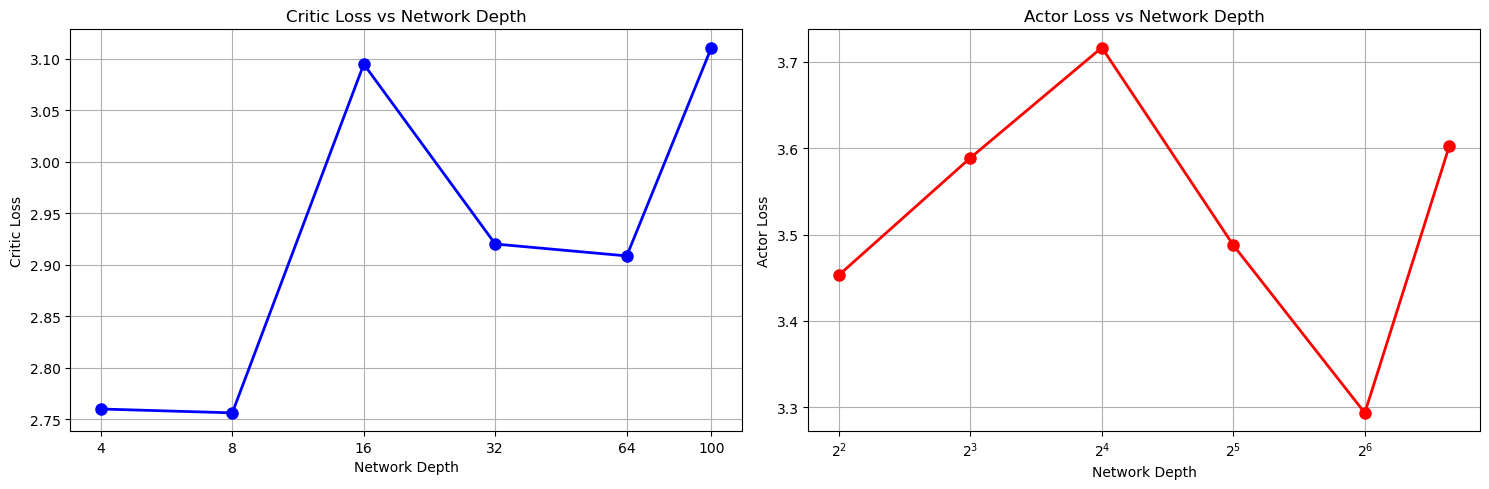


Numerical Values:
Depth | Critic Loss | Actor Loss
-----------------------------------
    4 |     2.7600 |     3.4531
    8 |     2.7563 |     3.5888
   16 |     3.0948 |     3.7164
   32 |     2.9202 |     3.4877
   64 |     2.9087 |     3.2936
  100 |     3.1109 |     3.6030


In [14]:
#BUFFER 4, testees set 1


import matplotlib.pyplot as plt
import numpy as np

# Convert defaultdict to regular dictionaries for easier plotting
depths = list(critic_losses.keys())
critic_values = [critic_losses[d] for d in depths]
actor_values = [actor_losses[d] for d in depths]

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Critic Losses
ax1.plot(depths, critic_values, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Network Depth')
ax1.set_ylabel('Critic Loss')
ax1.set_title('Critic Loss vs Network Depth')
ax1.grid(True)
ax1.set_xscale('log', base=2)  # Use log scale for x-axis since depths vary widely

# Plot Actor Losses
ax2.plot(depths, actor_values, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Network Depth')
ax2.set_ylabel('Actor Loss')
ax2.set_title('Actor Loss vs Network Depth')
ax2.grid(True)
ax2.set_xscale('log', base=2)  # Use log scale for x-axis
ax1.set_xticks(depths)  # Set exact tick positions
ax1.set_xticklabels(depths)  # Set tick labels to original values

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Print the values in a table format
print("\nNumerical Values:")
print("Depth | Critic Loss | Actor Loss")
print("-" * 35)
for depth in depths:
    print(f"{depth:5d} | {critic_losses[depth]:10.4f} | {actor_losses[depth]:10.4f}")

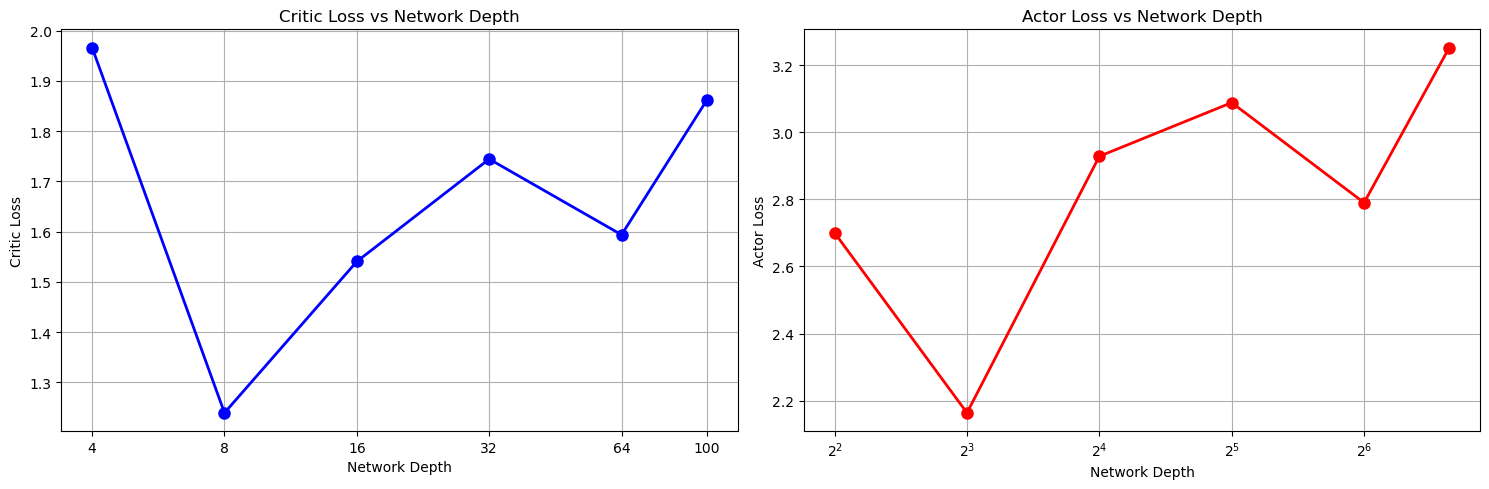


Numerical Values:
Depth | Critic Loss | Actor Loss
-----------------------------------
    4 |     1.9662 |     2.7002
    8 |     1.2390 |     2.1637
   16 |     1.5404 |     2.9284
   32 |     1.7443 |     3.0884
   64 |     1.5936 |     2.7900
  100 |     1.8614 |     3.2524


In [20]:
#BUFFER 64, testees set 2


import matplotlib.pyplot as plt
import numpy as np

# Convert defaultdict to regular dictionaries for easier plotting
depths = list(critic_losses.keys())
critic_values = [critic_losses[d] for d in depths]
actor_values = [actor_losses[d] for d in depths]

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Critic Losses
ax1.plot(depths, critic_values, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Network Depth')
ax1.set_ylabel('Critic Loss')
ax1.set_title('Critic Loss vs Network Depth')
ax1.grid(True)
ax1.set_xscale('log', base=2)  # Use log scale for x-axis since depths vary widely

# Plot Actor Losses
ax2.plot(depths, actor_values, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Network Depth')
ax2.set_ylabel('Actor Loss')
ax2.set_title('Actor Loss vs Network Depth')
ax2.grid(True)
ax2.set_xscale('log', base=2)  # Use log scale for x-axis
ax1.set_xticks(depths)  # Set exact tick positions
ax1.set_xticklabels(depths)  # Set tick labels to original values

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Print the values in a table format
print("\nNumerical Values:")
print("Depth | Critic Loss | Actor Loss")
print("-" * 35)
for depth in depths:
    print(f"{depth:5d} | {critic_losses[depth]:10.4f} | {actor_losses[depth]:10.4f}")

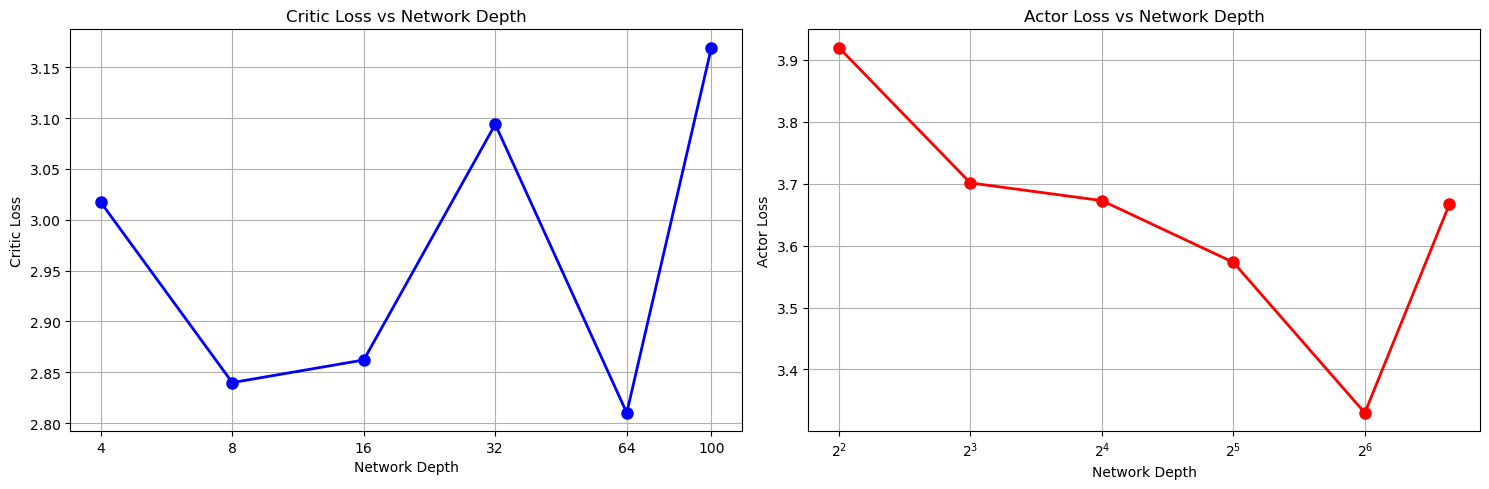


Numerical Values:
Depth | Critic Loss | Actor Loss
-----------------------------------
    4 |     3.0171 |     3.9200
    8 |     2.8398 |     3.7013
   16 |     2.8620 |     3.6728
   32 |     3.0938 |     3.5731
   64 |     2.8100 |     3.3298
  100 |     3.1693 |     3.6672


In [24]:
#BUFFER 4, testees set 2


import matplotlib.pyplot as plt
import numpy as np

# Convert defaultdict to regular dictionaries for easier plotting
depths = list(critic_losses.keys())
critic_values = [critic_losses[d] for d in depths]
actor_values = [actor_losses[d] for d in depths]

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Critic Losses
ax1.plot(depths, critic_values, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Network Depth')
ax1.set_ylabel('Critic Loss')
ax1.set_title('Critic Loss vs Network Depth')
ax1.grid(True)
ax1.set_xscale('log', base=2)  # Use log scale for x-axis since depths vary widely

# Plot Actor Losses
ax2.plot(depths, actor_values, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Network Depth')
ax2.set_ylabel('Actor Loss')
ax2.set_title('Actor Loss vs Network Depth')
ax2.grid(True)
ax2.set_xscale('log', base=2)  # Use log scale for x-axis
ax1.set_xticks(depths)  # Set exact tick positions
ax1.set_xticklabels(depths)  # Set tick labels to original values

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Print the values in a table format
print("\nNumerical Values:")
print("Depth | Critic Loss | Actor Loss")
print("-" * 35)
for depth in depths:
    print(f"{depth:5d} | {critic_losses[depth]:10.4f} | {actor_losses[depth]:10.4f}")